In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) \n[GCC 9.4.0]'

In [3]:
from cbf_opt import asif, cbf, dynamics
from refine_cbfs import cbf as refine_cbfs, dynamics as dynamics_hjr
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
from tqdm import tqdm
from refine_cbfs.utils import nominal_hjr_control
import numpy as np

In [4]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '32',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'lines.linewidth': 6.,
})
import matplotlib.animation as anim

In [5]:
class DubinsDynamics(dynamics.ControlAffineDynamics):

    
    def __init__(self, params, **kwargs):
        
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        self.v = params["v"]
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([self.v * jnp.cos(state[2]), self.v * jnp.sin(state[2]), 0])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 0, 1]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([
            [0, 0, self.v * jnp.sin(state[2])],
            [0, 0, -self.v * jnp.cos(state[2])], 
            [0, 0, 0]])

In [6]:
class DubinsCBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics: DubinsDynamics, params: dict = dict(), **kwargs) -> None:
        self.center = params["center"]
        self.r = params["r"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        return np.array([(state[0] - self.center[0]) ** 2 + (state[1] - self.center[1]) ** 2 - self.r ** 2])[0]

    def _grad_vf(self, state, time=0.0):
        return np.array([2 * (state[0] - self.center[0]), 2 * (state[1] - self.center[1]), 0])

In [7]:
def constraint_set(state):
    """A real-valud function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    bottom_left = jnp.array([4., 4.])
    length = jnp.array([2., 2.])
    return -jnp.min(jnp.array([state[0] - bottom_left[0], bottom_left[0] + length[0] - state[0], state[1] - bottom_left[1], bottom_left[1] + length[1] - state[1]]))


In [8]:
umin = -.5
umax = .5
dyn = DubinsDynamics({"v": 1.0, "dt": 0.05})
dubins_cbf = DubinsCBF(dyn, {"center": [5, 5], "r": jnp.sqrt(2.0)})

In [9]:
dyn_hjr = dynamics_hjr.HJControlAffineDynamics(dyn, control_space=hj.sets.Box(jnp.array([umin]), jnp.array([umax])))

state_domain = hj.sets.Box(lo=jnp.array([-5., -5., -jnp.pi]), hi=jnp.array([20., 20., jnp.pi]))
grid_resolution = (201, 201, 81) # can/should be increased if running on GPU, or if extra patient

In [10]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)

In [11]:
from refine_cbfs.utils import nominal_hjr_control

In [12]:
opt_ctrl = nominal_hjr_control.NominalControlHJ(dyn_hjr, grid, final_time=-40, time_intervals=101, solver_accuracy="low", padding=jnp.array([.2, .2, jnp.pi / 6]))

In [13]:
constraint_values = hj.utils.multivmap(constraint_set, jnp.arange(3))(grid.states)  # l(x)

In [14]:
cbf_table = dubins_cbf.vf(jnp.moveaxis(grid.states, -1, 0), 0.0)

In [15]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("very_high", value_postprocessor=backwards_reachable_tube(constraint_values))

In [16]:
# init_values = constraint_values
# initial_time = 0.
# final_time = -5.
# times = jnp.linspace(initial_time, final_time, 101)
# target_values_hjr = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)
# np.save("dubins/dubins_target_values_hjr.npy", target_values_hjr)
target_values_hjr = np.load('dubins/dubins_target_values_hjr.npy')

In [18]:
# init_values = cbf_table
# initial_time = 0.
# final_time = -10.
# times = jnp.linspace(initial_time, final_time, 201)
# target_values = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)
# np.save("dubins/dubins_target_values_wscbf.npy", target_values)
target_values = np.load('dubins/dubins_target_values_wscbf.npy')

In [19]:
import seaborn as sns

In [28]:
grid.states.shape

(201, 201, 81, 3)

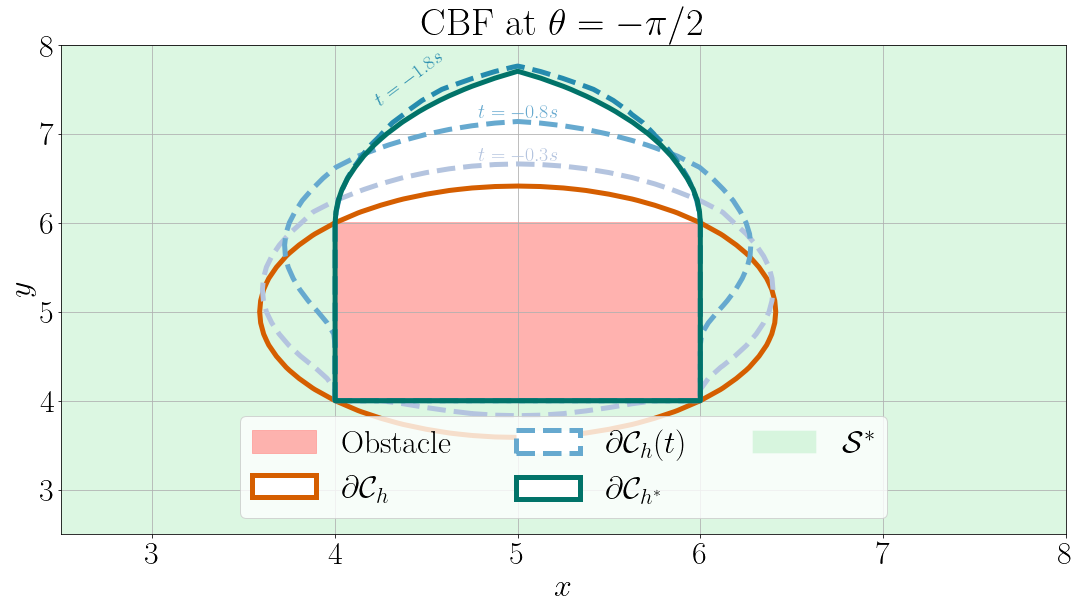

In [21]:
# sns.set_theme()
# plt.style.use('classic')
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
blue_colors = sns.color_palette("PuBuGn", 5).as_hex()
gen_colors = sns.color_palette("colorblind", 9).as_hex()
alt_colors = sns.color_palette("pastel", 9).as_hex()
proxy = [] 
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], constraint_values[..., 0], levels=[-10, 0], colors=alt_colors[3], alpha=0.8)
proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., 0], levels=[0, 50], colors=alt_colors[2], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., 0], levels=[0], colors=gen_colors[3], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[3], fc='white', lw=5)
        for pc in cont.collections]

cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[5][..., 0], levels=[0], colors=blue_colors[1], linestyles ='dashed', linewidths=5)
a = ax.clabel(cs, cs.levels, inline=False, fmt="$t=-0.3s$", fontsize=20, inline_spacing=-10, manual=[(5, 6.5)])
for l in a:
        l.set_va('bottom')
# ax.clabel(cs, inline=False, rightside_up=False, fontsize=20, fmt='$t=-0.3 s$', inline_spacing=3, colors = 'k')
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[15][..., 0], levels=[0], colors=blue_colors[2], linestyles ='dashed', linewidths=5)
contourlabel0 = ax.clabel(cs, inline=False, fontsize=20, fmt='$t=-0.8s$', inline_spacing=3, manual=[(5,7)])
for l in contourlabel0:
        l.set_va('bottom')
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[35][..., 0], levels=[0], colors=blue_colors[3], linestyles ='dashed', linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = blue_colors[2], fc='white', linestyle='dashed', lw=5)
        for pc in cs.collections]
contourlabel1 = ax.clabel(cs, inline=False, fontsize=20, fmt='$t=-1.8s$', inline_spacing=-30, manual=[(4.5, 7)])
for l in contourlabel1:
        l.set_va('bottom')

cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[-1][..., 0], levels=[0], colors=blue_colors[-1], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = blue_colors[-1], fc='white', lw=5)
        for pc in cs.collections]


proxy += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
        for pc in cs.collections]
ax.grid()
ax.set_xlabel("$x$")
# ax.text(contourlabel0)
# ax.text(contourlabel1)
ax.set_xlim([2.5, 8])
ax.set_ylim([2.5, 8])
ax.set_ylabel("$y$")
ax.set_title(r"CBF at $\theta=-\pi / 2$")
ax.legend(proxy, ["Obstacle", "$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$", "$\partial \mathcal{C}_{h^*}$", "$\mathcal{S}^*$"], ncol=3, loc='lower center')

In [47]:
def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()
    timestamp.set_text("Iteration = {}".format(i))
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[i][..., 21], levels=[0], colors=gen_colors[2])

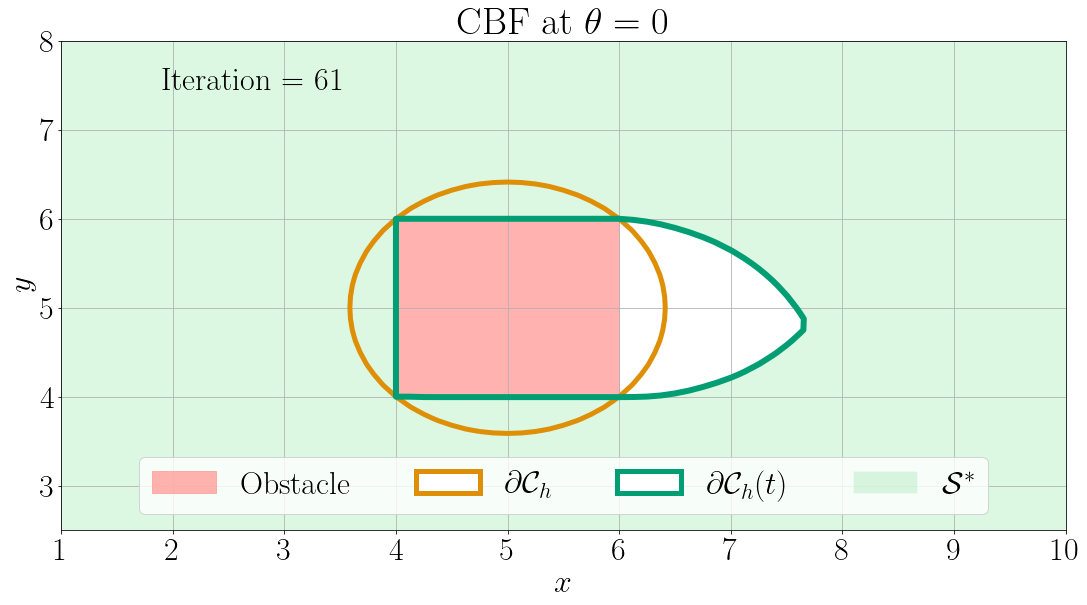

In [51]:
# sns.set_theme()
# plt.style.use('classic')
filename = "dubins_wscbf_cbf_hjr_contour.mp4"
fig, ax = plt.subplots(1, 1, figsize=(18,9 ))
blue_colors = sns.color_palette("PuBuGn", 5).as_hex()
gen_colors = sns.color_palette("colorblind", 9).as_hex()
alt_colors = sns.color_palette("pastel", 9).as_hex()
proxy = [] 
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], constraint_values[..., 21], levels=[-10, 0], colors=alt_colors[3], alpha=0.8)
proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., 21], levels=[0, 50], colors=alt_colors[2], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., 21], levels=[0], colors=gen_colors[1], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[1], fc='white', lw=5)
        for pc in cont.collections]

timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)


cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., 21], levels=[0], colors=gen_colors[2], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[2], fc='white', lw=5)
        for pc in cont.collections]


proxy += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
        for pc in cs.collections]
ax.grid()
ax.set_xlabel("$x$")
# ax.text(contourlabel0)
# ax.text(contourlabel1)
ax.set_xlim([1, 10])
ax.set_ylim([2.5, 8])
ax.set_ylabel("$y$")
ax.set_title(r"CBF at $\theta=0$")
ax.legend(proxy, ["Obstacle", "$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$", "$\mathcal{S}^*$"], ncol=4, loc='lower center')

render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, target_values.shape[0] * 5 // 16, interval=100)
animation.save(filename, writer='ffmpeg')

In [64]:
opt_ctrl = nominal_hjr_control.NominalControlHJNP(dyn_hjr, grid, final_time=-30, time_intervals=101, solver_accuracy="low", padding=jnp.array([.2, .2, jnp.pi / 6]))
opt_ctrl.solve(target=jnp.array([6, 7, 0]))
np.save("dubins/dubins_opt_ctrl_vfs_update.npy", opt_ctrl.tv_vf)
# opt_ctrl.tv_vf = np.load("dubins/dubins_opt_ctrl_vfs.npy")

100%|##########| 30.0000/30.0 [04:31<00:00,  9.04s/sim_s]


In [86]:
alpha = lambda x: 5 * x
tabular_cbf = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf.vf_table = np.array(target_values[-1])
dubins_asif_ws = asif.ControlAffineASIF(dyn, tabular_cbf, alpha=alpha, nominal_policy=opt_ctrl.get_nominal_control)
dubins_asif = asif.ControlAffineASIF(dyn, dubins_cbf, alpha=alpha, nominal_policy=opt_ctrl.get_nominal_control)

In [97]:
x0 = np.array([2, 4, np.pi / 3])
states = [x0]
control = []
control_filt = []
control_filt_ws = []
x_filt = x0 
betas = []
states_filt = [x0]
x_filt_ws = x0
states_filt_ws = [x0]
vf_filt = [dubins_cbf.vf(x0, 0.)]
vf_filt_ws = [tabular_cbf.vf(x0, 0.)]
ts = np.arange(0, 6, .05)

x = x0
for i, t in enumerate(tqdm(ts)):  
    # if i % 5 == 0:
    input_nom = np.array(opt_ctrl.get_nominal_control(x, t))

    x = np.array(dyn.step(x, input_nom))
    x[2] = (x[2] + np.pi) % (2 * np.pi) - np.pi
    states.append(x)
    control.append(input_nom)

for i, t in enumerate(tqdm(ts)):   
    # if i % 5 == 0: 
    input_mod = np.atleast_1d(dubins_asif(x_filt))

    x_filt = np.array(dyn.step(x_filt, input_mod))
    x_filt[2] = (x_filt[2] + np.pi) % (2 * np.pi) - np.pi
    states_filt.append(x_filt)
    vf_filt.append(dubins_cbf.vf(x_filt, 0.))
    control_filt.append(input_mod)

for i, t in enumerate(tqdm(ts)):
    # if i % 5 == 0:
    # input_mod_ws = np.array([0])
    try:
        input_mod_ws = np.atleast_1d(np.clip(dubins_asif_ws(x_filt_ws), umin, umax))
    except:
        input_nom = np.array(opt_ctrl.get_nominal_control(x, t))

    x_filt_ws = np.array(dyn.step(x_filt_ws, input_mod_ws))
    x_filt_ws[2] = (x_filt_ws[2] + np.pi) % (2 * np.pi) - np.pi
    states_filt_ws.append(x_filt_ws)
    vf_filt_ws.append(tabular_cbf.vf(x_filt_ws, t))
    control_filt_ws.append(input_mod_ws)


  7%|▋         | 8/120 [00:06<01:25,  1.30it/s]

ERROR in osqp_update_upper_bound: lower bound must be lower than or equal to upper bound


  8%|▊         | 9/120 [00:08<02:04,  1.12s/it]

ERROR in osqp_update_upper_bound: lower bound must be lower than or equal to upper bound


  8%|▊         | 10/120 [00:10<02:30,  1.37s/it]

ERROR in osqp_update_upper_bound: lower bound must be lower than or equal to upper bound


  9%|▉         | 11/120 [00:11<02:39,  1.47s/it]

ERROR in osqp_update_upper_bound: lower bound must be lower than or equal to upper bound


 10%|█         | 12/120 [00:13<02:45,  1.53s/it]

ERROR in osqp_update_upper_bound: lower bound must be lower than or equal to upper bound


 11%|█         | 13/120 [00:14<02:41,  1.51s/it]

ERROR in osqp_update_upper_bound: lower bound must be lower than or equal to upper bound


 12%|█▏        | 14/120 [00:16<02:44,  1.55s/it]

ERROR in osqp_update_upper_bound: lower bound must be lower than or equal to upper bound


 12%|█▎        | 15/120 [00:18<02:59,  1.71s/it]

ERROR in osqp_update_upper_bound: lower bound must be lower than or equal to upper bound


 13%|█▎        | 16/120 [00:21<03:29,  2.01s/it]

ERROR in osqp_update_upper_bound: lower bound must be lower than or equal to upper bound


100%|██████████| 120/120 [01:45<00:00,  1.14it/s]


In [25]:
import pickle as pkl

In [77]:
traj_data = dict()
traj_data['nominal'] = {'times': ts, 'state': np.array(states), 'control': np.array(control)}
pkl.dump(traj_data, open("dubins/traj_data_wrong_cbf4.pkl", "wb"))

In [78]:
traj_data['cbf'] = {'times': ts, 'state': np.array(states_filt), 'control': np.array(control_filt), 'vf': np.array(vf_filt)}
pkl.dump(traj_data, open("dubins/traj_data_wrong_cbf4.pkl", "wb"))

In [79]:

traj_data['cbvf'] = {'times': ts, 'state': np.array(states_filt_ws), 'control': np.array(control_filt_ws), 'vf': np.array(vf_filt_ws)}
traj_data['x_start'] = x0
traj_data['x_goal'] = np.array([6., 7., 0.])
pkl.dump(traj_data, open("dubins/traj_data_wrong_cbf4.pkl", "wb"))

In [31]:
import pickle as pkl
traj_data = pkl.load(open("dubins/traj_data_wrong_cbf2.pkl", "rb"))
nominal_traj = traj_data['nominal']
cbf_traj = traj_data['cbf']
cbvf_traj = traj_data['cbvf']
ts = nominal_traj['times']
states = nominal_traj['state']
control = nominal_traj['control']
states_filt = cbf_traj['state']
vf_filt = cbf_traj['vf']
control_filt = cbf_traj['control']
states_filt_ws = cbvf_traj['state']
control_filt_ws = cbvf_traj['control']
vf_filt_ws = cbvf_traj['vf']

In [52]:
target_values.shape

(201, 201, 201, 81)

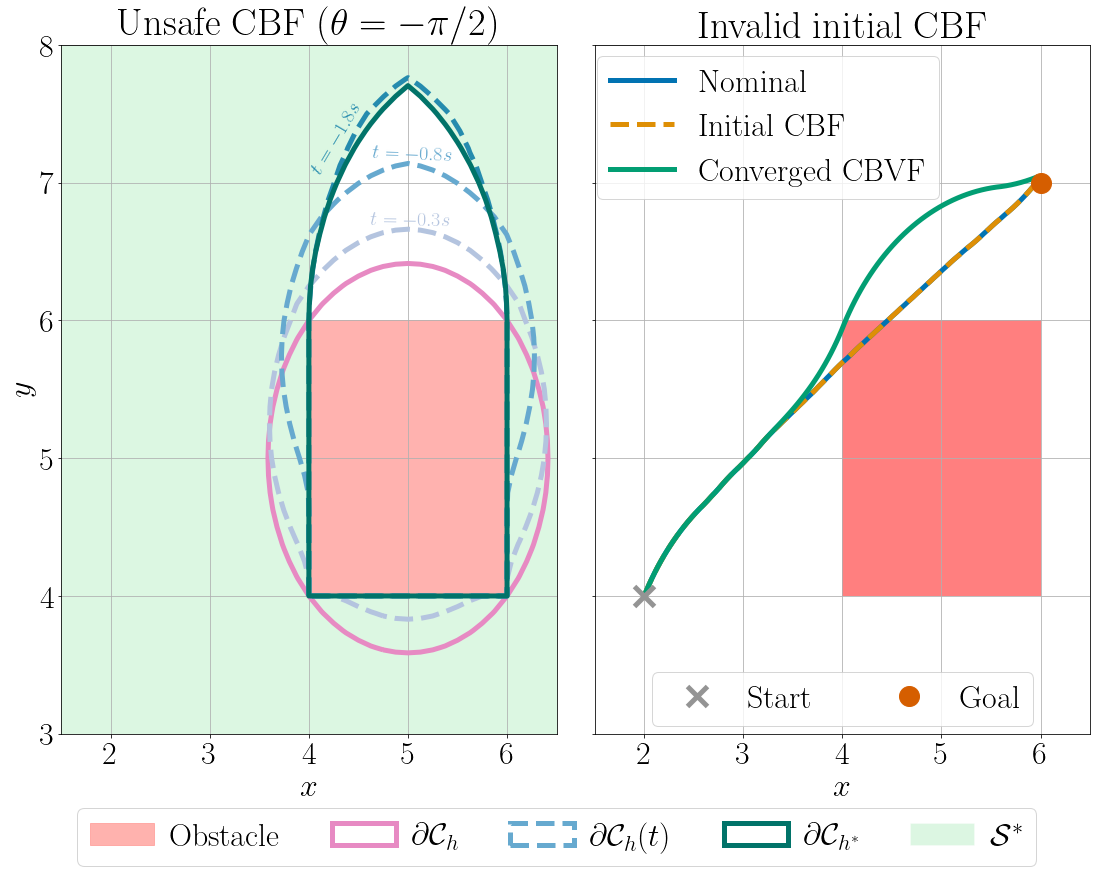

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(16, 12 ), sharey=True)
blue_colors = sns.color_palette("PuBuGn", 5).as_hex()
gen_colors = sns.color_palette("Set2", 9).as_hex()
alt_colors = sns.color_palette("pastel", 9).as_hex()
proxy = [] 
ax=axs[0]
offset = 0
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], constraint_values[..., offset], levels=[-10, 0], colors=alt_colors[3], alpha=0.8)
proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., offset], levels=[0, 50], colors=alt_colors[2], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., offset], levels=[0], colors=gen_colors[3], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[3], fc='white', lw=5)
        for pc in cont.collections]

cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[5][..., offset], levels=[0], colors=blue_colors[1], linestyles ='dashed', linewidths=5)
a = ax.clabel(cs, cs.levels, inline=False, fmt="$t=-0.3s$", fontsize=20, inline_spacing=-10, manual=[(5, 6.5)])
for l in a:
        l.set_va('bottom')
# ax.clabel(cs, inline=False, rightside_up=False, fontsize=20, fmt='$t=-0.3 s$', inline_spacing=3, colors = 'k')
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[15][..., offset], levels=[0], colors=blue_colors[2], linestyles ='dashed', linewidths=5)
contourlabel0 = ax.clabel(cs, inline=False, fontsize=20, fmt='$t=-0.8s$', inline_spacing=3, manual=[(5,7)])
for l in contourlabel0:
        l.set_va('bottom')
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[35][..., offset], levels=[0], colors=blue_colors[3], linestyles ='dashed', linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = blue_colors[2], fc='white', linestyle='dashed', lw=5)
        for pc in cs.collections]
contourlabel1 = ax.clabel(cs, inline=False, fontsize=20, fmt='$t=-1.8s$', inline_spacing=-30, manual=[(4.5, 7)])
for l in contourlabel1:
        l.set_va('bottom')

cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[-1][..., offset], levels=[0], colors=blue_colors[-1], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = blue_colors[-1], fc='white', lw=5)
        for pc in cs.collections]


proxy += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
        for pc in cs.collections]
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel('$y$')
# ax.text(contourlabel0)
# ax.text(contourlabel1)
ax.set_xlim([1.5, 6.5])
ax.set_ylim([3, 8])
# ax.set_ylabel("$y$")
ax.set_title(r"Unsafe CBF ($\theta=-\pi / 2$)")


pal = sns.color_palette("colorblind")
ax=axs[1]
sns.set_palette("colorblind")
# ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], value_function[-1][..., 0], levels=[0], colors='green')
ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], constraint_values[..., 0], levels=[-10, 0], colors='r', alpha=.5)

ax.set_xlim([1.5, 6.5])
ax.set_ylim([3, 8])
target = np.array([6., 7., 0.])

last_idx = np.linalg.norm(np.array(states)[:,:2] - target[:2], axis=1).argmin(axis=0)
last_idx_2 = np.linalg.norm(np.array(states_filt)[:,:2] - target[:2], axis=1).argmin(axis=0)
last_idx_3 = np.linalg.norm(np.array(states_filt_ws)[:,:2] - target[:2], axis=1).argmin(axis=0)
ax.plot(np.array(states)[:last_idx, 0], np.array(states)[:last_idx, 1], label='Nominal', linewidth=5)
ax.plot(np.array(states_filt)[:last_idx_2, 0], np.array(states_filt)[:last_idx_2, 1], '--', label='Initial CBF', color=pal[1], linewidth=5)
ax.plot(np.array(states_filt_ws)[:last_idx_3, 0], np.array(states_filt_ws)[:last_idx_3, 1], label='Converged CBVF', color=pal[2], linewidth=5)


l1 = ax.plot(x0[0], x0[1], 'x', markersize=20, mew=5, color=pal[7])
l2 = ax.plot(target[0], target[1], 'o', markersize=20, color=pal[3])
miscs = [l1, l2]

ax.set_xlabel('$x$')
axs[1].set_title('Invalid initial CBF')
ax.grid()
# ax.legend()
fig.tight_layout()
axs[0].legend(proxy, ["Obstacle", "$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$", "$\partial \mathcal{C}_{h^*}$", "$\mathcal{S}^*$"], ncol=5, loc='center', bbox_to_anchor=[1, -.15], columnspacing=1.6, handletextpad=0.5)
leg = axs[1].legend([misc[0] for misc in miscs], ['Start', 'Goal'], ncol=2, bbox_to_anchor=[.5, 0.05], loc='center', frameon=True, handletextpad=0.6)
axs[1].legend(bbox_to_anchor=[.35, 0.88], ncol=1, columnspacing=1.5, handletextpad=0.8, loc='center', frameon=True)
axs[1].add_artist(leg)
fig.savefig('dubins/dubins_plot.pdf', bbox_inches='tight')

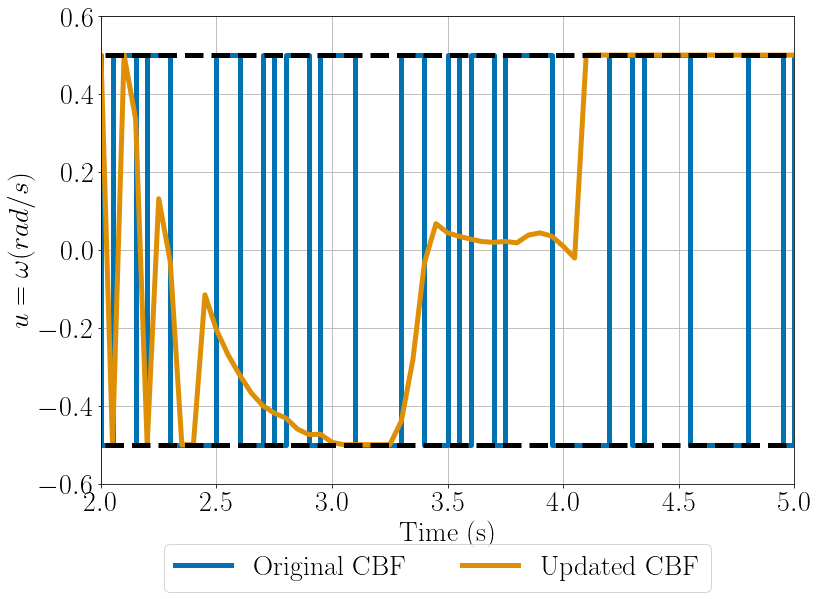

In [31]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.set_palette("colorblind")
ax.step(ts[:last_idx_2], control_filt[:last_idx_2], label='Original CBF', linewidth=5)
ax.plot(ts[:last_idx_3], control_filt_ws[:last_idx_3], label='Updated CBF', linewidth=5)
ax.plot(ts, np.ones_like(ts) * 0.5, '--k', linewidth=5)
ax.plot(ts, np.ones_like(ts) * -0.5, '--k', linewidth=5)
ax.set_xlim([2, 5])
ax.set_ylim([-.6, .6])
ax.set_xlabel("Time (s)")
ax.set_ylabel("$u=\omega (rad/s)$")
ax.legend(bbox_to_anchor=(0.9, -0.1), ncol=2)
ax.grid()
fig.tight_layout()

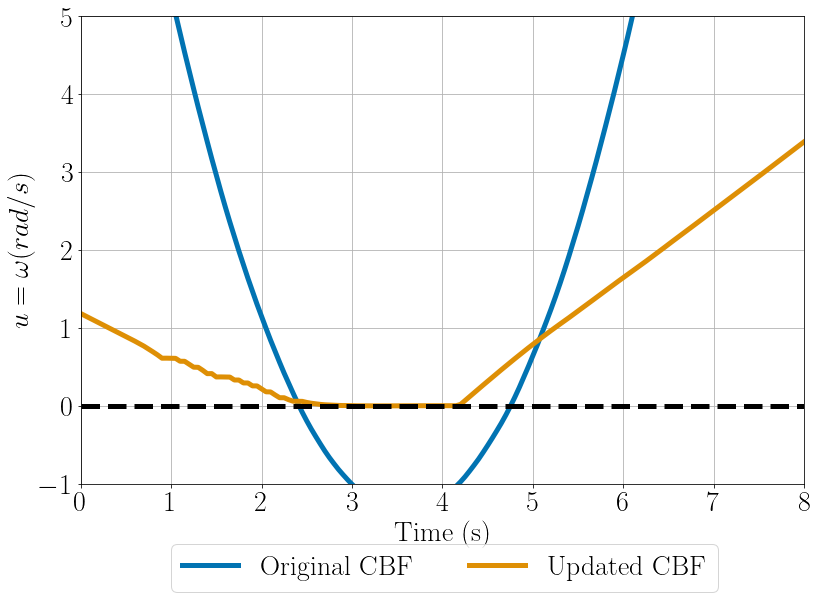

In [32]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.set_palette("colorblind")
ax.plot(ts[:last_idx_2], vf_filt[:last_idx_2], label='Original CBF', linewidth=5)
ax.plot(ts[:last_idx_3], vf_filt_ws[:last_idx_3], label='Updated CBF', linewidth=5)
ax.plot(ts, np.ones_like(ts) * 0.0, '--k', linewidth=5)
ax.set_xlim([0, 8])
ax.set_ylim([-1, 5])
ax.set_xlabel("Time (s)")
ax.set_ylabel("$u=\omega (rad/s)$")
ax.legend(bbox_to_anchor=(0.9, -0.1), ncol=2)
ax.grid()
fig.tight_layout()

In [ ]:
# elem1=go.Isosurface(x=np.array(grid.states[..., 0][::4, ::4, ::4]).ravel(),
#                              y=np.array(grid.states[..., 1][::4, ::4, ::4]).ravel(),
#                              z=np.array(grid.states[..., 2][::4, ::4, ::4]).ravel(),
#                              value=np.array(target_values_hjr[-1][::4, ::4, ::4]).ravel(),
#                              colorscale="jet",
#                              isomin=0,
#                              surface_count=1,
#                              isomax=0)
# elem2 = go.Scatter3d(x=np.array(target[0]), y=np.array(target[1]), z=np.array(target[2]))
# elem3 = go.Scatter3d(x=np.array(states)[:, 0], y=np.array(states)[:, 1], z=np.array(states)[:, 2])
# elem4 = go.Scatter3d(x=np.array(states[0][0]), y=np.array(states[0][1]), z=np.array(states[0][2]))


# fig = go.Figure(data=[elem1, elem2, elem3, elem4])

In [ ]:
# py.offline.iplot(fig, filename='3d-surface-mesh')